<a href="https://colab.research.google.com/github/nelson0216/final-project/blob/main/Final20221216_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##ref
##上課講義 CNN_Transfer_Learning_Part1.pdf
##transfer learning CNN: https://www.kaggle.com/code/orion99/transfer-learning-cnn

##要改modelbest_dir和pred_dir!!!!!!!!!!!改filenumber就好

filenumber = 3
modelbest_dir = '/content/drive/MyDrive/Colab Notebooks/Final/.hdf5/Final20221216_modelbest_'+str(filenumber)+'.hdf5'
pred_dir = "/content/drive/MyDrive/Colab Notebooks/Final/predict/pred20221216_"+str(filenumber)+".csv"

In [ ]:
##load data: give permission to load data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##import packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from keras.preprocessing import image
import os
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.datasets import load_files
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

from tensorflow.keras.applications import vgg16
from keras.applications import InceptionResNetV2
from keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras.applications import Xception
from keras.applications import InceptionV3


In [ ]:
##load data: data augmentation, standerize, and generate data
##https://keras.io/zh/preprocessing/image/
##https://www.twblogs.net/a/5e5366e9bd9eee2117c3e89f

train_path = "/content/drive/MyDrive/Colab Notebooks/Final/train(85% data training)"
valid_path = "/content/drive/MyDrive/Colab Notebooks/Final/valid(85% data training)"
test_path = "/content/drive/MyDrive/Colab Notebooks/Final/test"

##data augmentation and standerize
##training data做標準化和data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    )
##valid和test data只要標準化就好
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

##generate data
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224,224), batch_size=30) #就是講義上的train_batches
valid_generator = valid_datagen.flow_from_directory(valid_path, target_size=(224,224), batch_size=30) #就是講義上的valid_batches
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224,224), batch_size=1, shuffle=False) #就是講義上的test_batches

##是說用datagen.flow_from_directory(...)應該就等於datagen.fit(...)嗎?

Found 3132 images belonging to 4 classes.
Found 552 images belonging to 4 classes.
Found 492 images belonging to 1 classes.


In [ ]:
##build the model by transfer learning: feature extraction, load pretrained model and freeze weights


#base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
#base_model = InceptionResNetV2(include_top=False,weights='imagenet',input_tensor=Input(shape=(224,224, 3)))
# base_model = Xception(include_top=False,weights='imagenet',input_tensor=Input(shape=(224,224, 3)))
base_model = InceptionV3(include_top=False,weights='imagenet',input_tensor=Input(shape=(224,224, 3)))

for layer in base_model.layers:
  layer.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_102 (Batch  (None, 111, 111, 32  96         ['conv2d_102[0][0]']             
 Normalization)                 )                                                      

In [ ]:
#build the model by transfer learning: classification, use the base model to build new model

#last_layer = base_model.get_layer('block5_pool')
#last_layer = base_model.get_layer('conv_7b_ac')
# last_layer = base_model.get_layer('block14_sepconv2_act')
last_layer = base_model.get_layer('mixed10')
last_output = last_layer.output

x = Flatten()(last_output)

# x = Dense(128, activation='relu', name='FC_2')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
# x = Dense(64, activation='relu', name='FC_3')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
# x = Dense(32, activation='relu', name='FC_4')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
x = Dense(64, activation='relu', name='FC_3')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(4, activation='softmax', name='softmax')(x)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_102 (Batch  (None, 111, 111, 32  96         ['conv2d_102[0][0]']             
 Normalization)                 )                                                           

In [ ]:
##compile the model

new_model.compile(Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
##train the model: train and save the model
##https://blog.csdn.net/mlp750303040/article/details/89207658

checkpointer = ModelCheckpoint(filepath=modelbest_dir, verbose=1, save_best_only=True)

##如果是要直接繼續train之前的model
#from keras.models import load_model
#old_model = load_model('/content/drive/MyDrive/Colab Notebooks/Prob2_epoch_100.h5')
#history = old_model.fit(train_generator, steps_per_epoch=4, callbacks=[checkpointer],validation_data=valid_generator, validation_steps=2, epochs=20, verbose=2)
#old_model.save(model_dir)


##train new model
history = new_model.fit(train_generator, steps_per_epoch=4, callbacks=[checkpointer],validation_data=valid_generator, validation_steps=2, epochs=80, verbose=2)


Epoch 1/80

Epoch 1: val_loss improved from inf to 5.00507, saving model to /content/drive/MyDrive/Colab Notebooks/Final/.hdf5/Final20221216_modelbest_2.hdf5
4/4 - 147s - loss: 2.1734 - accuracy: 0.2344 - val_loss: 5.0051 - val_accuracy: 0.4375 - 147s/epoch - 37s/step
Epoch 2/80

Epoch 2: val_loss did not improve from 5.00507
4/4 - 128s - loss: 1.7415 - accuracy: 0.2969 - val_loss: 5.8548 - val_accuracy: 0.4219 - 128s/epoch - 32s/step
Epoch 3/80

Epoch 3: val_loss did not improve from 5.00507
4/4 - 116s - loss: 1.9112 - accuracy: 0.2266 - val_loss: 5.7292 - val_accuracy: 0.3906 - 116s/epoch - 29s/step
Epoch 4/80

Epoch 4: val_loss did not improve from 5.00507
4/4 - 108s - loss: 1.9441 - accuracy: 0.3594 - val_loss: 5.5801 - val_accuracy: 0.3594 - 108s/epoch - 27s/step
Epoch 5/80

Epoch 5: val_loss did not improve from 5.00507
4/4 - 96s - loss: 1.6569 - accuracy: 0.3594 - val_loss: 6.0522 - val_accuracy: 0.2344 - 96s/epoch - 24s/step
Epoch 6/80

Epoch 6: val_loss improved from 5.00507 t

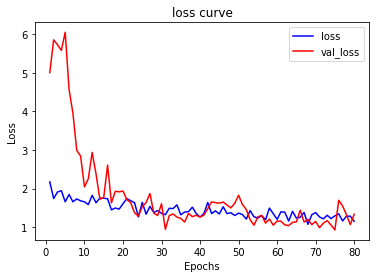

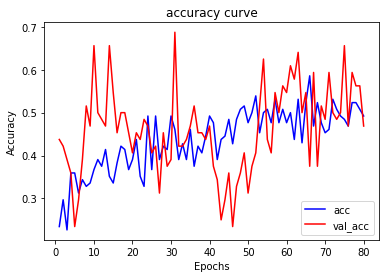

In [ ]:
##train the model: draw the loss curve and accuracy curve

df_history = pd.DataFrame(history.history)
acc = df_history['accuracy']
val_acc = df_history['val_accuracy']
loss = df_history['loss']
val_loss = df_history['val_loss']
epochs = range(1, len(acc) + 1)

##loss
plt.plot(epochs, loss, color="blue", label='loss')
plt.plot(epochs, val_loss, color="red", label='val_loss')
plt.title('loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("loss curve.png")
#files.download("loss curve.png")
plt.show()

##acc
plt.plot(epochs, acc, color="blue", label='acc')
plt.plot(epochs, val_acc, color="red", label='val_acc')
plt.title('accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig("accuracy curve.png")
#files.download("accuracy curve.png")
plt.show()

In [ ]:
##predict the test data: load weight and predict

new_model.load_weights(modelbest_dir)
prediction = new_model.predict(test_generator)


492/492 [==============================] - 301s 609ms/step


In [ ]:
##predict the test data
##transfer learning CNN: https://www.kaggle.com/code/orion99/transfer-learning-cnn
li_predtyp = prediction.argmax(axis=-1)
li_prednam=[]
for i in range(prediction.shape[0]):
  li_prednam.append(str(i)+".jpg")


##存檔
df_prednam = pd.DataFrame(li_prednam, columns=['Name'])
df_predtyp = pd.DataFrame(li_predtyp, columns=['Type'])
df_pred = pd.concat([df_prednam,df_predtyp],axis=1)

df_pred.to_csv(pred_dir, index=False)
print("done")

done
